In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern
from typing import Tuple, Dict, Literal, Optional
import time
from typing import Dict, Tuple
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


In [9]:
# Set data paths
DATA_DIR = "./data"
SOURCE_FILE = "fer2013.csv"

# Load data from local path
df = pd.read_csv(SOURCE_FILE)

# print basic info
print("Loaded FER-2013 with shape:", df.shape)
print(df["Usage"].value_counts())
df.head()

# Ensure training directory exists
os.makedirs((DATA_DIR), exist_ok=True)

# We use for training and validation the "Training" and "PublicTest"
train_df = df[df['Usage']== 'Training'].copy()
vali_df = df[df['Usage'] == 'PublicTest'].copy()
test_df = df[df['Usage'] == 'PrivateTest'].copy() 

# Storing train and test data frames
train_df.to_csv("./data/fer2013_train.csv", encoding='utf-8', index=False)
vali_df.to_csv("./data/fer2013_validation.csv", encoding='utf-8', index=False)
test_df.to_csv("./data/fer2013_test.csv", encoding='utf-8', index=False)


Loaded FER-2013 with shape: (35887, 3)
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


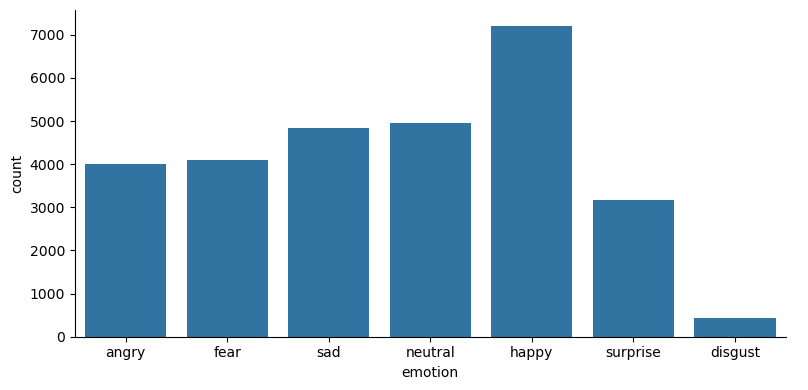

In [10]:
# Define label mapping
label_map = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}
# Map integer labels to emotion names
sns.catplot(data=train_df.replace({'emotion': label_map}), kind='count', x='emotion', height=4, aspect=2)

#sns.countplot(x ='emotion', data = trai_df)
plt.show()

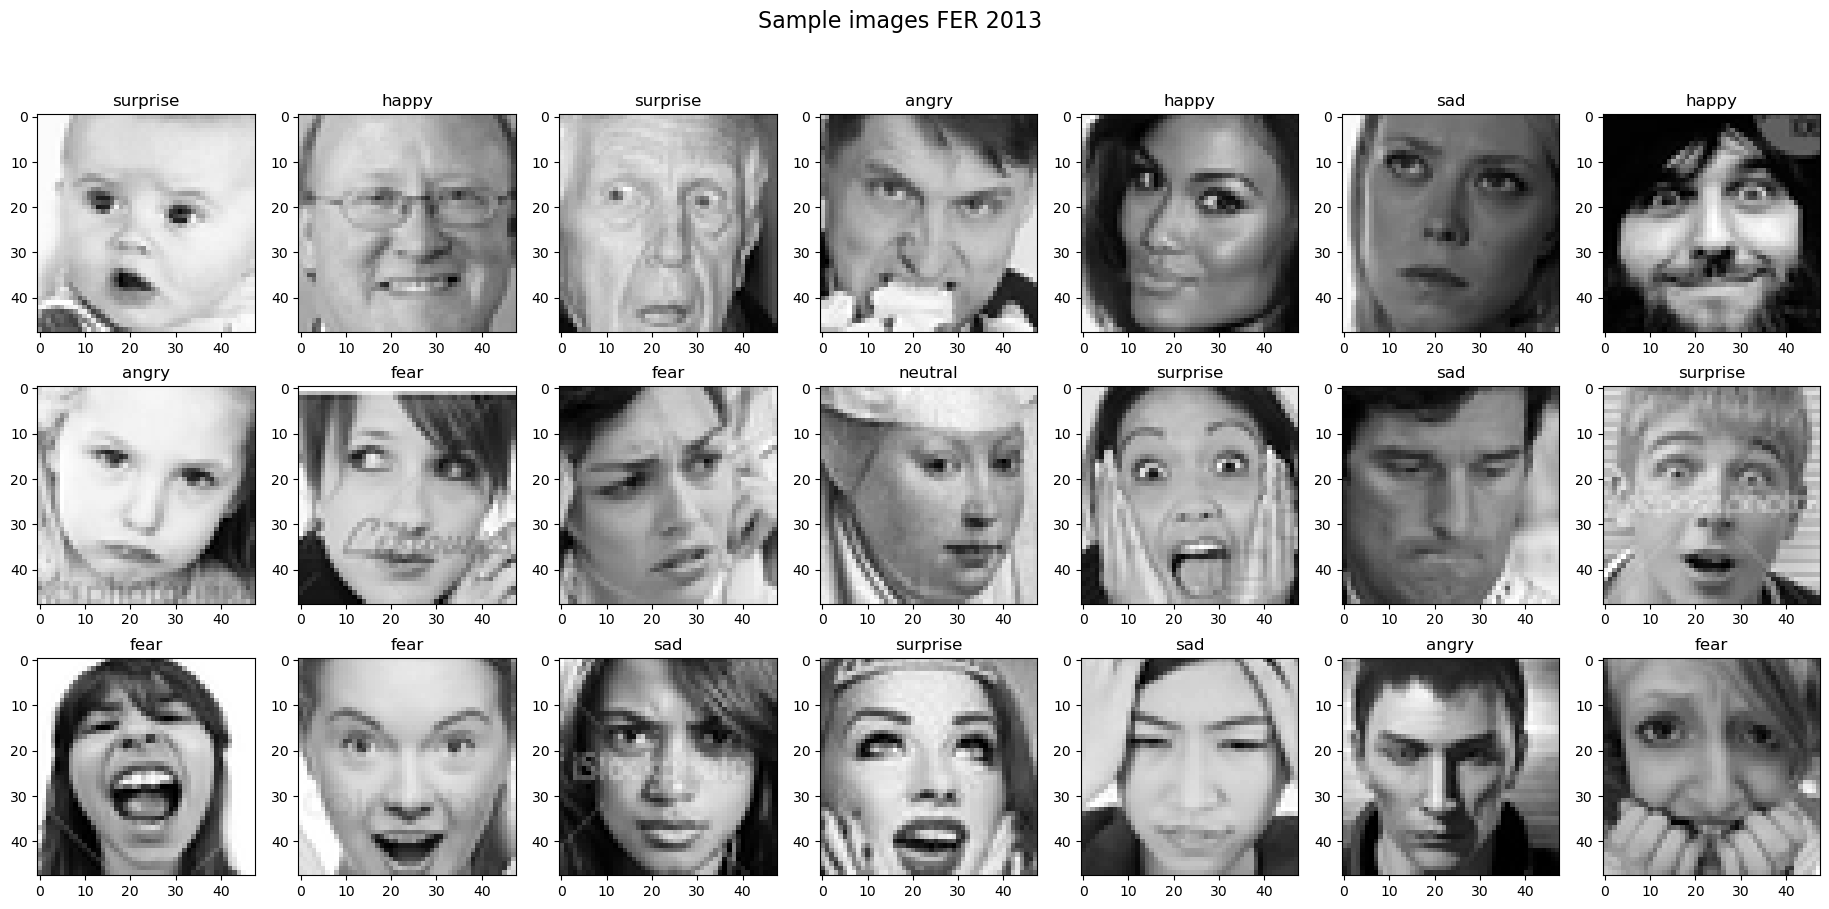

In [11]:
# Now making some plots
random_rows = df.sample(n=21, random_state=43)
imgs = [np.fromstring(pixels, sep=' ').reshape(48, 48) for pixels in random_rows['pixels']]
lbl =  random_rows['emotion'].values

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(23, 10))
fig.suptitle('Sample images FER 2013', fontsize=16)

# Loop through each subplot and customize
for i in range(7):
    for j in range(3):
        ax = axes[j, i]
        ax.imshow(imgs[j*7+i], cmap="gray") 
        ax.set_title('%s'%(label_map[lbl[j*7+i]]))
        #ax.grid(True)
plt.show()

In [14]:
# Create function for converting pixels string to 48x48 numpy array
def pixels_to_array(pixels_str):
   """
    Convert pixel string into a 48x48 NumPy array.
    Input:
    - pixels_str = string of 2304 grayscale pixel values (e.g., "70 80 82 ...")
    Output:
    - NumPy array of shape (48, 48) with dtype uint8 representing the image
    """
   return np.fromstring(pixels_str, sep=" ", dtype=np.uint8).reshape(48, 48)

In [15]:
def load_split(path):
    """Load a pre-split FER-2013 CSV file and return normalized image and label arrays.
    Input:
    - path = path to CSV file (e.g., './data/fer2013_train.csv')
    Output:
    - X = NumPy array of shape (N, 48, 48) with normalized pixel values in [0, 1]
    - y = NumPy array of shape (N,) with integer emotion labels (0–6)
    """
    # read CSV file and convert pixels to arrays and labels to integers
    df = pd.read_csv(path)
    X = np.stack(df["pixels"].apply(pixels_to_array))
    y = df["emotion"].to_numpy(dtype=np.int64)

    # Normalize pixel values to [0, 1]
    X = X.astype(np.float32) / 255.0 
    print(f"{path}: X={X.shape}, y={y.shape}")
    return X, y


# Load each split
X_train, y_train = load_split("./data/fer2013_train.csv")
X_val, y_val     = load_split("./data/fer2013_validation.csv")
X_test, y_test   = load_split("./data/fer2013_test.csv")

./data/fer2013_train.csv: X=(28709, 48, 48), y=(28709,)
./data/fer2013_validation.csv: X=(3589, 48, 48), y=(3589,)
./data/fer2013_test.csv: X=(3589, 48, 48), y=(3589,)


In [17]:
# DEBUG, i think all model support "weighted" as class weight option
# So this might be redundant

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {label_map[c]: w for c, w in zip(classes, class_weights)}
print("Class weights (use for sklearn models):")
print(class_weights_dict)

Class weights (use for sklearn models):
{'angry': np.float64(1.0266046844269623), 'disgust': np.float64(9.406618610747051), 'fear': np.float64(1.0010460615781582), 'happy': np.float64(0.5684387684387684), 'sad': np.float64(0.8491274770777877), 'surprise': np.float64(1.293372978330405), 'neutral': np.float64(0.8260394187886635)}


In [ ]:
APPLY_PCA: bool = True
PCA_VARIANCE: float = 0.95   # keep 95% variance (ignored if PCA_N_COMPONENTS is set)
PCA_N_COMPONENTS: Optional[int] = None  # e.g., 256; set to None to use PCA_VARIANCE

In [ ]:
# A compact PCA for fuzzy model (low-dimensional)
MAKE_FUZZY_FRIENDLY_COPY: bool = True
FUZZY_PCA_N_COMPONENTS: int = 32

In [23]:
def extract_features(X, params=FEATURE_PARAMS):
    """
    Extract multiple types of features (raw, HOG, LBP) from grayscale images.

    Input:
    - X: NumPy array of shape (N, 48, 48)
    - params: dict containing 'hog' and 'lbp' parameter sets

    Output:
    - X_raw: flattened & normalized raw pixel features (N, 2304)
    - X_hog: HOG feature vectors (N, ?)
    - X_lbp: normalized LBP histograms (N, bins)
    """
    # --- Raw pixel features ---
    X_raw = X.reshape(len(X), -1).astype(np.float32) / 255.0

    # --- HOG features ---
    hog_params = params["hog"]
    X_hog = np.asarray([hog(img, **hog_params) for img in X], dtype=np.float32)

    # --- LBP features ---
    lbp_params = params["lbp"]
    P, R, method = lbp_params["P"], lbp_params["R"], lbp_params["method"]
    n_bins = P + 2 if method == "uniform" else int(X.max()) + 1
    X_lbp = []
    for img in X:
        lbp = local_binary_pattern(img, P=P, R=R, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
        hist = hist.astype(np.float32)
        hist /= (hist.sum() + 1e-8)
        X_lbp.append(hist)
    X_lbp = np.asarray(X_lbp, dtype=np.float32)

    print(f"Extracted: RAW={X_raw.shape}, HOG={X_hog.shape}, LBP={X_lbp.shape}")
    return X_raw, X_hog, X_lbp

In [ ]:
FEATURE_PARAMS = {
    "hog": {"orientations": 9, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2),
        "block_norm": "L2-Hys", "transform_sqrt": True, "feature_vector": True},
    "lbp": {"P": 8, "R": 1.0, "method": "uniform"}}

# Build features for all splits
X_train_raw, X_train_hog, X_train_lbp = extract_features(X_train, FEATURE_PARAMS)
X_val_raw,   X_val_hog,   X_val_lbp  = extract_features(X_val, FEATURE_PARAMS)
X_test_raw,  X_test_hog,  X_test_lbp = extract_features(X_test, FEATURE_PARAMS)


c:\ProgramData\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracted: RAW=(28709, 2304), HOG=(28709, 900), LBP=(28709, 10)
Extracted: RAW=(3589, 2304), HOG=(3589, 900), LBP=(3589, 10)
Extracted: RAW=(3589, 2304), HOG=(3589, 900), LBP=(3589, 10)
Feature shapes:
  train : (28709, 2304)
  public: (3589, 2304)
  private: (3589, 2304)


In [ ]:
# Train scalers on training data
scaler_raw = StandardScaler().fit(X_train_raw)
scaler_hog = StandardScaler().fit(X_train_hog)
scaler_lbp = StandardScaler().fit(X_train_lbp)

# Apply scalers to all features
X_train_raw = scaler_raw.transform(X_train_raw)
X_val_raw   = scaler_raw.transform(X_val_raw)
X_test_raw  = scaler_raw.transform(X_test_raw)

X_train_hog = scaler_hog.transform(X_train_hog)
X_val_hog   = scaler_hog.transform(X_val_hog)
X_test_hog  = scaler_hog.transform(X_test_hog)

X_train_lbp = scaler_lbp.transform(X_train_lbp)
X_val_lbp   = scaler_lbp.transform(X_val_lbp)
X_test_lbp  = scaler_lbp.transform(X_test_lbp)


In [ ]:
# PCA (fit ONLY on train, apply to all)

pca = None
if APPLY_PCA:
    if PCA_N_COMPONENTS is not None:
        pca = PCA(n_components=PCA_N_COMPONENTS, svd_solver="auto", random_state=42)
    else:
        pca = PCA(n_components=PCA_VARIANCE, svd_solver="full", random_state=42)
    Xtr_feat = pca.fit_transform(Xtr_feat)
    Xpub_feat = pca.transform(Xpub_feat)
    Xpri_feat = pca.transform(Xpri_feat)
    if hasattr(pca, "n_components_"):
        print(f"PCA reduced to {pca.n_components_} dims; explained var ratio sum = {pca.explained_variance_ratio_.sum():.3f}")
    else:
        print("Applied PCA.")

In [ ]:
# Optional compact copy for fuzzy classifier

Xtr_fuzzy = Xpub_fuzzy = Xpri_fuzzy = None
pca_fuzzy = None
if MAKE_FUZZY_FRIENDLY_COPY:
    # If we already applied PCA and it is <= FUZZY_PCA_N_COMPONENTS, just reuse.
    if APPLY_PCA and Xtr_feat.shape[1] <= FUZZY_PCA_N_COMPONENTS:
        Xtr_fuzzy, Xpub_fuzzy, Xpri_fuzzy = Xtr_feat, Xpub_feat, Xpri_feat
        pca_fuzzy = pca  # same mapping
        print(f"Fuzzy copy: reused existing PCA features ({Xtr_feat.shape[1]} dims).")
    else:
        # Fit a separate PCA on the (optionally standardized) base features (without prior PCA)
        # Recompute base features quickly to avoid stacking PCA on PCA:
        Xtr_base = make_features(X_train, FEATURE_KIND)
        Xpub_base = make_features(X_public, FEATURE_KIND)
        Xpri_base = make_features(X_private, FEATURE_KIND)
        if APPLY_SCALER:
            sc_fuzzy = StandardScaler(with_mean=True, with_std=True)
            Xtr_base = sc_fuzzy.fit_transform(Xtr_base)
            Xpub_base = sc_fuzzy.transform(Xpub_base)
            Xpri_base = sc_fuzzy.transform(Xpri_base)
        pca_fuzzy = PCA(n_components=FUZZY_PCA_N_COMPONENTS, svd_solver="auto", random_state=42)
        Xtr_fuzzy = pca_fuzzy.fit_transform(Xtr_base)
        Xpub_fuzzy = pca_fuzzy.transform(Xpub_base)
        Xpri_fuzzy = pca_fuzzy.transform(Xpri_base)
        print(f"Fuzzy copy: PCA to {FUZZY_PCA_N_COMPONENTS} dims.")

In [ ]:
# Summary

def _shape(a): return None if a is None else tuple(a.shape)
print("\nFinal feature matrices:")
print("  Train :", _shape(Xtr_feat))
print("  Public:", _shape(Xpub_feat))
print("  Private:", _shape(Xpri_feat))
print("  (Fuzzy):", _shape(Xtr_fuzzy))

In [ ]:
# helpers

label_map = {
    0: "angry", 1: "disgust", 2: "fear", 3: "happy",
    4: "sad", 5: "surprise", 6: "neutral"
}
classes = np.array(sorted(np.unique(y_train)))

def class_weights_from_y(y: np.ndarray) -> Dict[int, float]:
    w = compute_class_weight("balanced", classes=classes, y=y)
    return {int(c): float(wi) for c, wi in zip(classes, w)}

CLASS_WEIGHTS = class_weights_from_y(y_train)

In [ ]:
def plot_conf_mat(cm: np.ndarray, title: str):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels([label_map[c] for c in classes], rotation=30, ha="right")
    ax.set_yticklabels([label_map[c] for c in classes])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", fontsize=8)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_model(name: str, model, Xtr, ytr, Xpub, ypub, Xpri, ypri):
    print(f"\n=== {name} ===")
    t0 = time.time()
    model.fit(Xtr, ytr)
    t_train = time.time() - t0

    for split_name, X, y in [("Public", Xpub, ypub), ("Private", Xpri, ypri)]:
        yp = model.predict(X)
        acc = accuracy_score(y, yp)
        print(f"{split_name} accuracy: {acc:.4f}")
        print("Classification report:")
        print(classification_report(y, yp, target_names=[label_map[c] for c in classes], zero_division=0))
        cm = confusion_matrix(y, yp, labels=classes)
        plot_conf_mat(cm, f"{name} — {split_name} Confusion Matrix")

    print(f"Train time: {t_train:.2f}s")
    return model

In [ ]:
# 1) SVM
# -----------------------
# Tip: RBF SVC can be slow on ~28k x 247; start with LinearSVC (fast baseline),
# then (optionally) try RBF SVC with modest C on a reduced subset or let it run.
svm_linear = LinearSVC(
    C=1.0,
    class_weight=CLASS_WEIGHTS,  # accepts dict or 'balanced'
    max_iter=5000,
    dual=False
)

svm_rbf = SVC(
    kernel="rbf",
    C=2.0,
    gamma="scale",
    class_weight=CLASS_WEIGHTS,
    probability=False
)

# choose which to run first
SVM_TO_RUN = "linear"  # "linear" or "rbf"
if SVM_TO_RUN == "linear":
    model_svm = evaluate_model("SVM (LinearSVC)", svm_linear, Xtr_feat, y_train, Xpub_feat, y_public, Xpri_feat, y_private)
else:
    model_svm = evaluate_model("SVM (RBF)", svm_rbf, Xtr_feat, y_train, Xpub_feat, y_public, Xpri_feat, y_private)


In [ ]:
# 2) MLP
# -----------------------
mlp = MLPClassifier(
    hidden_layer_sizes=(256,),   # good starting point
    activation="relu",
    alpha=1e-4,
    learning_rate="adaptive",
    learning_rate_init=1e-3,
    batch_size=256,
    max_iter=50,                 # keep small; early_stopping will usually stop earlier
    early_stopping=True,
    n_iter_no_change=5,
    verbose=False,
    random_state=42
)
model_mlp = evaluate_model("MLP", mlp, Xtr_feat, y_train, Xpub_feat, y_public, Xpri_feat, y_private)


In [ ]:
# 3) Random Forest
# -----------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)
model_rf = evaluate_model("Random Forest", rf, Xtr_feat, y_train, Xpub_feat, y_public, Xpri_feat, y_private)


In [ ]:
# 4) Simple Fuzzy Baseline (Fuzzy c-means + nearest-rule) — low-dim features
# -----------------------
# Your assignment mentions PyFUME; if you install and want to use it, swap this baseline
# with a PyFUME-based classifier trained on Xtr_fuzzy (<= ~32 dims). Below is a practical
# baseline using fuzzy c-means clustering (skfuzzy) per class, then classify by the
# nearest cluster center using membership-weighted distance.

try:
    import skfuzzy as fuzz

    assert Xtr_fuzzy is not None and Xtr_fuzzy.size > 0, "Xtr_fuzzy is missing; enable MAKE_FUZZY_FRIENDLY_COPY in Step 3."

    # hyperparameters
    CLUSTERS_PER_CLASS = 2
    MAXITER = 100
    M = 2.0  # fuzziness

    # learn class-wise cluster centers in fuzzy space
    centers = []
    labels_for_centers = []
    for c in classes:
        Xc = Xtr_fuzzy[y_train == c]
        # transpose to shape (features, samples) for skfuzzy.cmeans
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            Xc.T, c=CLUSTERS_PER_CLASS, m=M, error=1e-5, maxiter=MAXITER, init=None, seed=42
        )
        centers.append(cntr)  # (clusters_per_class, n_features)
        labels_for_centers += [c] * CLUSTERS_PER_CLASS
    centers = np.vstack(centers)
    labels_for_centers = np.array(labels_for_centers)

    def fuzzy_predict(Xf: np.ndarray) -> np.ndarray:
        # compute distances to all centers; assign to nearest center
        # (skfuzzy has cmeans_predict, but we can do euclidean here)
        # Xf: (N, d), centers: (K, d)
        diffs = Xf[:, None, :] - centers[None, :, :]
        dists2 = np.sum(diffs * diffs, axis=2)  # (N, K)
        nearest = np.argmin(dists2, axis=1)     # (N,)
        return labels_for_centers[nearest]

    # Evaluate fuzzy baseline
    print("\n=== Fuzzy Baseline (Fuzzy C-Means) ===")
    for split_name, Xf, y in [("Public", Xpub_fuzzy, y_public), ("Private", Xpri_fuzzy, y_private)]:
        yp = fuzzy_predict(Xf)
        acc = accuracy_score(y, yp)
        print(f"{split_name} accuracy: {acc:.4f}")
        print("Classification report:")
        print(classification_report(y, yp, target_names=[label_map[c] for c in classes], zero_division=0))
        cm = confusion_matrix(y, yp, labels=classes)
        plot_conf_mat(cm, f"Fuzzy Baseline — {split_name} Confusion Matrix")

except Exception as e:
    print("\n[Fuzzy baseline skipped]")
    print("Reason:", repr(e))
    print("Tip: Install scikit-fuzzy (skfuzzy) OR use PyFUME on Xtr_fuzzy/Xpub_fuzzy/Xpri_fuzzy "
          "for a proper fuzzy classifier per the assignment. Keep features low-dimensional (~32).")
